In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
%matplotlib inline

from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications.efficientnet import EfficientNetB5,preprocess_input

from sklearn import metrics

from joblib import dump, load

In [ ]:
# affectation de la variable d'environnement
environnement_collab = True

## Définiton des chemins selon la plateforme Jupyter/Colab

In [ ]:
if environnement_collab == True :
    # accès à Google Drive
    from google.colab import drive
    drive.mount('/content/drive')
    # chemin pour accéder aux DataFrame sur collab
    path = '/content/drive/MyDrive/Collab_Rakuten/data'
    
    # chemin pour pour accéder aux répertoire contenant les images d'entrainement/validaiton/test sur collab
    train_dir = '/content/drive/MyDrive/Collab_Rakuten/data/images_generator/train'
    test_dir = '/content/drive/MyDrive/Collab_Rakuten/data/images_generator/test'
    valid_dir = '/content/drive/MyDrive/Collab_Rakuten/data/images_generator/valid'

else :
    # chemin pour accéder aux DataFrame en local
    path = '../data/'
    # chemin pour pour accéder aux répertoire contenant les images d'entrainement/validaiton/test en local
    train_dir = "../data/images/generator/train/"
    test_dir = "../data/images/generator/test/"
    valid_dir = "../data/images/generator/valid/"

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Instanciation d'un ImageDataGenerator 
# Augmentation des données d'entrainement pour eviter le sur-apprentissage
train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   zoom_range = 1.2,
                                   horizontal_flip = True)

valid_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,)

test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

In [ ]:
batch_size = 32
image_size = 456

# Génération des tenseurs en modifiant la taille des images d'entrée
train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size = (image_size,image_size), 
                                                    batch_size = batch_size,
                                                    class_mode =  'sparse')

valid_generator = valid_datagen.flow_from_directory(valid_dir,
                                                    target_size = (image_size,image_size), 
                                                    batch_size = batch_size,
                                                    class_mode =  'sparse')

test_generator = test_datagen.flow_from_directory(test_dir, 
                                                  target_size = (image_size,image_size), 
                                                  batch_size = batch_size,
                                                  class_mode =  'sparse')

Found 9510 images belonging to 27 classes.
Found 2378 images belonging to 27 classes.
Found 5096 images belonging to 27 classes.


In [ ]:
# Nombre de classes en sortie
n_class = 27

In [ ]:
# tailes des échantillons
nb_img_train = train_generator.samples
nb_img_test = test_generator.samples

In [ ]:
# Modèle amélorié en partant des point du modèle 1 (EfficientNet5 avec 5 époque) 
# Unfreeze des 20 dernières couches en laissant les couches de BatchNormalization
# Réduction du learning rate

## Chargement de EfficientNetB5
effnet_unfreeze = EfficientNetB5(weights='imagenet', 
                                 include_top= False,
                                 input_shape = (image_size,image_size,3)) 

# Construction du modèle
pretrained_model_unfreeze = Sequential()
pretrained_model_unfreeze.add(effnet_unfreeze)
pretrained_model_unfreeze.add(GlobalAveragePooling2D()) 
pretrained_model_unfreeze.add(Dense(n_class, activation='softmax'))

# On freeze toutes les couches
for layer in effnet_unfreeze.layers: 
    layer.trainable = False

# On unfreeze les 20 dernières couches
for layer in effnet_unfreeze.layers[-20:]:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = True
    
pretrained_model_unfreeze.summary()

115263384/115263384 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb5 (Functional)  (None, 15, 15, 2048)     28513527  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 27)                55323     
                                                                 
Total params: 28,568,850
Trainable params: 5,066,907
Non-trainable params: 23,501,943
_________________________________________________________________


In [ ]:
pretrained_model_unfreeze.compile(optimizer= 'adam', 
                                  loss = 'sparse_categorical_crossentropy',
                                  metrics=['accuracy'])

In [ ]:
# entrainement du modèle
history_unfreeze= pretrained_model_unfreeze.fit(train_generator, 
                                                epochs = 10,
                                                steps_per_epoch = nb_img_train//batch_size,
                                                validation_data = test_generator,
                                                validation_steps = nb_img_test//batch_size)

Epoch 1/10
297/297 [==============================] - 5976s 20s/step - loss: 2.3128 - accuracy: 0.3308 - val_loss: 1.6511 - val_accuracy: 0.5094
Epoch 2/10
297/297 [==============================] - 692s 2s/step - loss: 2.0199 - accuracy: 0.4118 - val_loss: 1.5623 - val_accuracy: 0.5369
Epoch 3/10
297/297 [==============================] - 689s 2s/step - loss: 1.9493 - accuracy: 0.4238 - val_loss: 1.5448 - val_accuracy: 0.5513
Epoch 4/10
297/297 [==============================] - 689s 2s/step - loss: 1.8686 - accuracy: 0.4466 - val_loss: 1.5119 - val_accuracy: 0.5572
Epoch 5/10
297/297 [==============================] - 682s 2s/step - loss: 1.8146 - accuracy: 0.4521 - val_loss: 1.5076 - val_accuracy: 0.5694
Epoch 6/10
297/297 [==============================] - 686s 2s/step - loss: 1.7598 - accuracy: 0.4739 - val_loss: 1.5034 - val_accuracy: 0.5584
Epoch 7/10
297/297 [==============================] - 696s 2s/step - loss: 1.7265 - accuracy: 0.4800 - val_loss: 1.4720 - val_accuracy: 0.58

In [ ]:


dump(pretrained_model_unfreeze, "/content/drive/MyDrive/Collab_Rakuten/data/model_image_effb5_fine.pkl")

['/content/drive/MyDrive/Collab_Rakuten/data/model_image_effb5_fine.pkl']

In [ ]:
pretrained_model_unfreeze.save_weights("/content/drive/MyDrive/Collab_Rakuten/data/model_image_effb5_fine_weights.h5")

In [ ]:
# Récupération de l'accuray 
acc = history_unfreeze.history['accuracy']
val_acc = history_unfreeze.history['val_accuracy']
loss = history_unfreeze.history['loss']
val_loss = history_unfreeze.history['val_loss']

In [ ]:
# Evalutation des modèles sur des données qu'ils n'ont jamais vus
score_b5_unfreeze = pretrained_model_unfreeze.evaluate(test_generator)

print("Accuracy - Modèle EfficentB5 :", score_b5_unfreeze[1])

160/160 [==============================] - 81s 507ms/step - loss: 1.4962 - accuracy: 0.5726
Accuracy - Modèle EfficentB5 : 0.5726059675216675


In [ ]:
epochs = range(1, len(acc)+1)

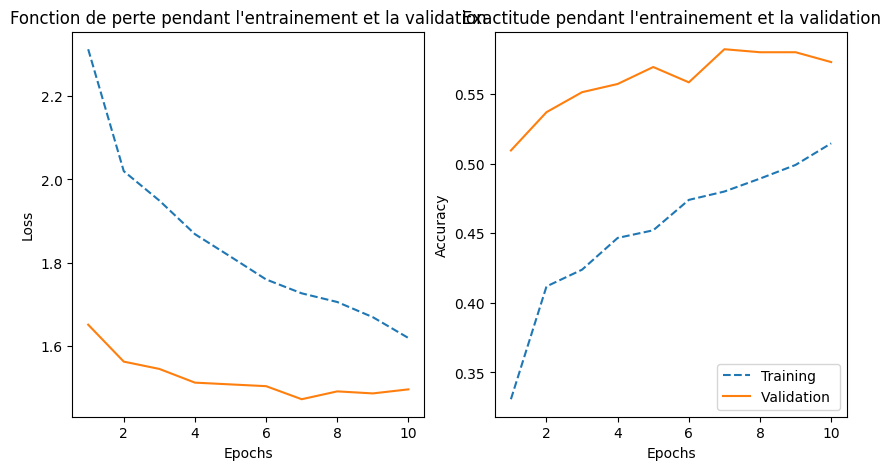

In [ ]:
plt.figure(figsize = (10,5))
plt.subplot(121)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Fonction de perte pendant l\'entrainement et la validation")

plt.plot(epochs,loss, "--", label = "Training" )
plt.plot(epochs,val_loss,"-",label = "Validation ")

plt.subplot(122)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Exactitude pendant l\'entrainement et la validation")

plt.plot(epochs,acc, "--", label = "Training" )
plt.plot(epochs,val_acc,"-",label = "Validation ")
plt.legend();